The Data Table
Number of Records :  749
Number of Variables :  15
Variables :  ('Study Number', 'Sample ID', 'Product Type', 'Base Ingredient', 'Process Type', 'Sample Age (Weeks)', 'Difference From Fresh', 'Storage Conditions', 'Packaging Stabilizer Added', 'Transparent Window in Package', 'Processing Agent Stability Index', 'Preservative Added', 'Moisture (%)', 'Residual Oxygen (%)', 'Hexanal (ppm)')
Missing Values in Study Number :  0
Missing Values in Sample ID :  0
Missing Values in Process Type :  0
Missing Values in Product Type :  0
Missing Values in Processing Agent Stability Index :  0
Missing Values in Sample Age (Weeks) :  0
Missing Values in Difference From Fresh :  0
Missing Values in Base Ingredient :  109
Missing Values in Moisture (%) :  236
Missing Values in Packaging Stabilizer Added :  282
Missing Values in Storage Conditions :  294
Missing Values in Residual Oxygen (%) :  329
Missing Values in Hexanal (ppm) :  460
Missing Values in Preservative Added :  480
Missing

Difference From Fresh,Sample Age (Weeks),Processing Agent Stability Index,ProcessTypeA,ProcessTypeB,ProcessTypeC,ProductTypeA,ProductTypeB,ProductTypeC,ProductTypeD,ProductTypeE,ProductTypeF,ProductTypeG,ProductTypeH,ProductTypeI,BaseIngredientA,BaseIngredientB,BaseIngredientC,BaseIngredientD,BaseIngredientE,BaseIngredientF,PackagingStabilizerAdded,PackagingStabilizerNotAdded,WarmClimate,ColdClimate,HighTemperatureandHumidity,PreservativeAdded,PreservativeNotAdded
0,0,16.2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,10,16.2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,14,16.2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.3,16,16,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2.7,18,16,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,16,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
34,5,16,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
22,11,16,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
44,13,16,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
50,15,16,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


6.757522126691974
[-11.55594615  -0.37587192  -0.46340084  -7.81469384   2.62988491
 -10.27099094   9.34260728  -1.61326403  20.12167554   0.79017885
   2.04607034   2.62988491  13.55224208   7.28281356   7.06731754
  -2.58921079  -0.46340084   3.05261163   0.43796262  -4.87875889
  -2.0391523   -1.92268392   2.65909902   4.73064916  -0.25389602
  -2.25362087  -4.83628715]
Mean squared error: 98.59
Variance score: 0.14


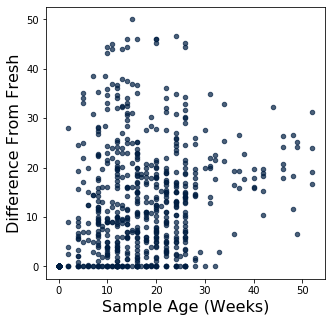

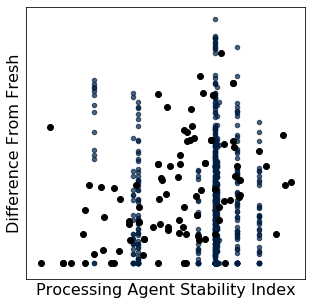

In [45]:
from datascience import Table # Including Table functions from datascience package into the running instance
import os# including os package into running instance
from datascience.predicates import are# Import 'are' from 'predicates' in 'datascience' module for comparison
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt  # To visualize
from sklearn.metrics import mean_squared_error
%matplotlib inline

from sklearn.linear_model import LinearRegression

#---------------------------------------------------------------------------------------------------------------------

#LOAD DATA

#---------------------------------------------------------------------------------------------------------------------

#Loading data from CSV file URL address 
InputFilepath='https://raw.githubusercontent.com/babloomarkose/DataInPython/master/ShelfLifePrediction'
ProductTable=Table().read_table(InputFilepath+'/Dataset.csv')

#Print the Data Table
print("The Data Table")
#ProductTable.show(5) # Show only the first 5 records

#---------------------------------------------------------------------------------------------------------------------

#EXPLORATORY DATA ANALYSIS

#---------------------------------------------------------------------------------------------------------------------

print("Number of Records : " ,  ProductTable.num_rows)
print("Number of Variables : ",ProductTable.num_columns)
print("Variables : ",ProductTable.labels)

#Find Number of Missing Values in each column
print("Missing Values in Study Number : ",ProductTable.num_rows-sum(not np.isnan(x) for x in ProductTable['Study Number']))
print("Missing Values in Sample ID : ",(ProductTable['Sample ID'] == 'nan').sum())

print("Missing Values in Process Type : ",(ProductTable['Process Type'] == 'nan').sum())
print("Missing Values in Product Type : ",(ProductTable['Product Type'] == 'nan').sum())
print("Missing Values in Processing Agent Stability Index : ",ProductTable.num_rows-sum(not np.isnan(x) for x in ProductTable['Processing Agent Stability Index']))
print("Missing Values in Sample Age (Weeks) : ",ProductTable.num_rows-sum(not np.isnan(x) for x in ProductTable['Sample Age (Weeks)']))
print("Missing Values in Difference From Fresh : ",ProductTable.num_rows-sum(not np.isnan(x) for x in ProductTable['Difference From Fresh']))

print("Missing Values in Base Ingredient : ",(ProductTable['Base Ingredient'] == 'nan').sum())
print("Missing Values in Moisture (%) : ",ProductTable.num_rows-sum(not np.isnan(x) for x in ProductTable['Moisture (%)']))
print("Missing Values in Packaging Stabilizer Added : ",(ProductTable['Packaging Stabilizer Added'] == 'nan').sum())
print("Missing Values in Storage Conditions : ",(ProductTable['Storage Conditions'] == 'nan').sum())
print("Missing Values in Residual Oxygen (%) : ",ProductTable.num_rows-sum(not np.isnan(x) for x in ProductTable['Residual Oxygen (%)']))
print("Missing Values in Hexanal (ppm) : ",ProductTable.num_rows-sum(not np.isnan(x) for x in ProductTable['Hexanal (ppm)']))
print("Missing Values in Preservative Added : ",(ProductTable['Preservative Added'] == 'nan').sum())
print("Missing Values in Transparent Window in Package : ",(ProductTable['Transparent Window in Package'] == 'nan').sum())


'''ProductTable.pivot_hist('Product Type','Base Ingredient',label='Product Type to Base Ingredient')
ProductTable.pivot_hist('Product Type','Process Type',label='Product Type to Process Type')
ProductTable.pivot_hist('Product Type','Storage Conditions',label='Product Type to Storage Conditions')
ProductTable.pivot_hist('Product Type','Packaging Stabilizer Added',label='Product Type to Packaging Stabilizer Added')
'''

#Count The number of Unique Values in string variables
print('Product Type:',Counter(ProductTable['Product Type'] ))
print('Base Ingredient: ',Counter(ProductTable['Base Ingredient'] ))
print('Process Type: ',Counter(ProductTable['Process Type'] ))
print('Storage Conditions: ',Counter(ProductTable['Storage Conditions'] ))
print('Packaging Stabilizer Added: ',Counter(ProductTable['Packaging Stabilizer Added'] ))
print('Preservative Added: ',Counter(ProductTable['Preservative Added'] ))
print('Transparent Window in Package: ',Counter(ProductTable['Transparent Window in Package'] ))
print('Processing Agent Stability Index: ',Counter(ProductTable['Processing Agent Stability Index'] ))

#Remove Transparent Window in Package from further consideration as non-null values  belong to only one category 
ProductTable=ProductTable.drop('Transparent Window in Package')
#Also Residual Oxygen, Moisture (%) and Hexanal (ppm) are charecteristics of aged samples. 
#Hence is of little use for prediction of shelf life. hence droping those columns also from further analysis
ProductTable=ProductTable.drop('Moisture (%)')
ProductTable=ProductTable.drop('Residual Oxygen (%)')
ProductTable=ProductTable.drop('Hexanal (ppm)')
#Also drop colomn Study Number/Sample ID as this is not affecting shelf life in anyway
ProductTable=ProductTable.drop('Study Number')
ProductTable=ProductTable.drop('Sample ID')

#Drop Duplicate Entries is there are any
pandasDF=ProductTable.to_df()
pandasDF.drop_duplicates(keep='first',inplace=True)#inplace=True modify original record
ProductTable=Table.from_df(pandasDF)

# I am considering 'Difference From Fresh' as my dependent variable. And once the prediction is done and we have an 
#equation, substitute 20 for it to find the shelf life of any given product
ProductTable=ProductTable.move_column('Difference From Fresh',0)
ProductTable=ProductTable.move_column('Sample Age (Weeks)',1)
ProductTable=ProductTable.move_column('Processing Agent Stability Index',2)
ProductTable=ProductTable.move_column('Process Type',3)

#Transforming variable Process Type
# 3 Categories in Process Type,Process Type:  Counter({'C': 534, 'A': 167, 'B': 48})
#so add 2 dummy variable ProcessTypeC,ProcessTypeA,ProcessTypeB
#Add two new colomns and initialise to 0
ProductTable.append_column('ProcessTypeC',0)
ProductTable['ProcessTypeC']=ProductTable.apply(lambda x: 1 if x=='C' else 0,'Process Type')
ProductTable.append_column('ProcessTypeB',0)
ProductTable['ProcessTypeB']=ProductTable.apply(lambda x: 1 if x=='B' else 0,'Process Type')
ProductTable.append_column('ProcessTypeA', 0)
ProductTable['ProcessTypeA']=ProductTable.apply(lambda x: 1 if x=='A' else 0,'Process Type')
ProductTable=ProductTable.drop('Process Type')
ProductTable=ProductTable.move_column('ProcessTypeA',3)
ProductTable=ProductTable.move_column('ProcessTypeB',4)
ProductTable=ProductTable.move_column('ProcessTypeC',5)

#Transforming variable Product Type
ProductTable.append_column('ProductTypeA',0)
ProductTable.append_column('ProductTypeB',0)
ProductTable.append_column('ProductTypeC',0)
ProductTable.append_column('ProductTypeD',0)
ProductTable.append_column('ProductTypeE',0)
ProductTable.append_column('ProductTypeF',0)
ProductTable.append_column('ProductTypeG',0)
ProductTable.append_column('ProductTypeH',0)
ProductTable.append_column('ProductTypeI',0)

ProductTable['ProductTypeA']=ProductTable.apply(lambda x: 1 if x=='A' else 0,'Product Type')
ProductTable['ProductTypeB']=ProductTable.apply(lambda x: 1 if x=='B' else 0,'Product Type')
ProductTable['ProductTypeC']=ProductTable.apply(lambda x: 1 if x=='C' else 0,'Product Type')
ProductTable['ProductTypeD']=ProductTable.apply(lambda x: 1 if x=='D' else 0,'Product Type')
ProductTable['ProductTypeE']=ProductTable.apply(lambda x: 1 if x=='E' else 0,'Product Type')
ProductTable['ProductTypeF']=ProductTable.apply(lambda x: 1 if x=='F' else 0,'Product Type')
ProductTable['ProductTypeG']=ProductTable.apply(lambda x: 1 if x=='G' else 0,'Product Type')
ProductTable['ProductTypeH']=ProductTable.apply(lambda x: 1 if x=='H' else 0,'Product Type')
ProductTable['ProductTypeI']=ProductTable.apply(lambda x: 1 if x=='I' else 0,'Product Type')

ProductTable=ProductTable.drop('Product Type')
#Transforming variable Product Type
#When base ingredient is not given all these fields will be 0
ProductTable.append_column('BaseIngredientA',0)
ProductTable.append_column('BaseIngredientB',0)
ProductTable.append_column('BaseIngredientC',0)
ProductTable.append_column('BaseIngredientD',0)
ProductTable.append_column('BaseIngredientE',0)
ProductTable.append_column('BaseIngredientF',0)
ProductTable['BaseIngredientA']=ProductTable.apply(lambda x: 1 if x=='A' else 0,'Base Ingredient')
ProductTable['BaseIngredientB']=ProductTable.apply(lambda x: 1 if x=='B' else 0,'Base Ingredient')
ProductTable['BaseIngredientC']=ProductTable.apply(lambda x: 1 if x=='C' else 0,'Base Ingredient')
ProductTable['BaseIngredientD']=ProductTable.apply(lambda x: 1 if x=='D' else 0,'Base Ingredient')
ProductTable['BaseIngredientE']=ProductTable.apply(lambda x: 1 if x=='E' else 0,'Base Ingredient')
ProductTable['BaseIngredientF']=ProductTable.apply(lambda x: 1 if x=='F' else 0,'Base Ingredient')
ProductTable=ProductTable.drop('Base Ingredient')

#Transforming variable Packaging Stabilizer Added
#When information on Packaging Stabilizer Added is not given, these two fields will be 0
ProductTable.append_column('PackagingStabilizerAdded',0)
ProductTable['PackagingStabilizerAdded']=ProductTable.apply(lambda x: 1 if x=='Y' else 0,'Packaging Stabilizer Added')
ProductTable.append_column('PackagingStabilizerNotAdded',0)
ProductTable['PackagingStabilizerNotAdded']=ProductTable.apply(lambda x: 1 if x=='N' else 0,'Packaging Stabilizer Added')
ProductTable=ProductTable.drop('Packaging Stabilizer Added')

#Transforming variable Storage Conditions
#When information on Storage Conditions is not given, these three fields will be 0
ProductTable.append_column('WarmClimate',0)
ProductTable.append_column('ColdClimate',0)
ProductTable.append_column('HighTemperatureandHumidity',0)
ProductTable['WarmClimate']=ProductTable.apply(lambda x: 1 if x=='Warm Climate' else 0,'Storage Conditions')
ProductTable['ColdClimate']=ProductTable.apply(lambda x: 1 if x=='Cold Climate' else 0,'Storage Conditions')
ProductTable['HighTemperatureandHumidity']=ProductTable.apply(lambda x: 1 if x=='High Temperature and Humidity' else 0,'Storage Conditions')
ProductTable=ProductTable.drop('Storage Conditions')

#Transforming variable Preservative Added
#When information on Preservative Added is not given, these two fields will be 0
ProductTable.append_column('PreservativeAdded',0)
ProductTable.append_column('PreservativeNotAdded',0)
ProductTable['PreservativeAdded']=ProductTable.apply(lambda x: 1 if x=='Y' else 0,'Preservative Added')
ProductTable['PreservativeNotAdded']=ProductTable.apply(lambda x: 1 if x=='N' else 0,'Preservative Added')
ProductTable=ProductTable.drop('Preservative Added')

#Cleaned Data Table
ProductTable.show(10)


#Analyze relation between Dependent variable Difference From Fresh and Sample Age (Weeks)
ProductTable.scatter('Sample Age (Weeks)','Difference From Fresh')
ProductTable.scatter('Processing Agent Stability Index','Difference From Fresh')

#---------------------------------------------------------------------------------------------------------------------

#SEPERATE DATA INTO TRAINING-SET AND TEST-SET

#---------------------------------------------------------------------------------------------------------------------

#Separate Table rows into Test(ProductTableTest) and Train data
ProductTableTest=ProductTable.sample(k=100)
#Remove entries in test set (ProductTableTest) from training set
ProductTable=ProductTable.append(ProductTableTest)
pandasDF=ProductTable.to_df()
#keep=False removes all occurance of duplicate values,ensuring data in test and train do not overlap inplace=True modify original record
pandasDF.drop_duplicates(keep=False,inplace=True)
ProductTable=Table.from_df(pandasDF)

#---------------------------------------------------------------------------------------------------------------------

#LINEAR REGRESSION

#---------------------------------------------------------------------------------------------------------------------

pandasDFTest=ProductTableTest.to_df()
pandasDF=ProductTable.to_df()

X_Test = pandasDFTest[['ProductTypeA','ProductTypeB','ProductTypeC','ProductTypeD','ProductTypeE','ProductTypeF','ProductTypeG','ProductTypeH','ProductTypeI',
                  'BaseIngredientA','BaseIngredientB','BaseIngredientC','BaseIngredientD','BaseIngredientE','BaseIngredientF',
                  'ProcessTypeA','ProcessTypeB','ProcessTypeC',
                  'Sample Age (Weeks)','WarmClimate','ColdClimate','HighTemperatureandHumidity',
                  'PackagingStabilizerAdded','PackagingStabilizerNotAdded',
                  'Processing Agent Stability Index','PreservativeAdded','PreservativeNotAdded']] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y_Test = pandasDFTest['Difference From Fresh']


X_Train = pandasDF[['ProductTypeA','ProductTypeB','ProductTypeC','ProductTypeD','ProductTypeE','ProductTypeF','ProductTypeG','ProductTypeH','ProductTypeI',
                  'BaseIngredientA','BaseIngredientB','BaseIngredientC','BaseIngredientD','BaseIngredientE','BaseIngredientF',
                  'ProcessTypeA','ProcessTypeB','ProcessTypeC',
                  'Sample Age (Weeks)','WarmClimate','ColdClimate','HighTemperatureandHumidity',
                  'PackagingStabilizerAdded','PackagingStabilizerNotAdded',
                  'Processing Agent Stability Index','PreservativeAdded','PreservativeNotAdded']]  
Y_Train = pandasDF['Difference From Fresh']

# Create linear regression object.
mlr= LinearRegression()

# Fit linear regression.
mlr.fit( X_Train, Y_Train)                  

# Get the slope and intercept of the line best fit.
print(mlr.intercept_)
print(mlr.coef_)

# Make predictions using the testing set
Y_PRED = mlr.predict(X_Test)

# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(Y_Test, Y_PRED))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_Test, Y_PRED))

# Plot outputs
plt.scatter(Y_PRED, Y_Test,  color='black')
#plt.plot(X_Test, Y_PRED, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()


Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Variance score: 0.47


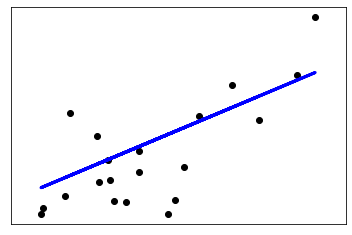

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes = datasets.load_diabetes()


# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()